In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os,time,librosa,warnings,glob, pickle

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D, MaxPooling1D
from tensorflow.keras import regularizers
from keras.models import Model,Sequential,load_model, model_from_json
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import tensorflow as tf

warnings.filterwarnings("ignore")


In [16]:
df = pd.read_csv("csvs/big_audio_feats_corr2.csv")
X  = df.iloc[:, :-1].values
y = df["EMOTION"].values

encoder = OneHotEncoder()
scaler = StandardScaler()

y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()
X_scaled = scaler.fit_transform(X)
X_train, X_toval, y_train, y_toval = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_toval, y_toval, test_size=0.20, random_state=42, shuffle=True)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_val = np.expand_dims(X_val, axis=2)

X_train.shape, X_val.shape, X_test.shape,  y_train.shape, y_val.shape, y_test.shape

((17830, 162, 1),
 (3566, 162, 1),
 (892, 162, 1),
 (17830, 6),
 (3566, 6),
 (892, 6))

In [4]:
# kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)
# bias_regularizer = regularizers.l2(1e-4)
# activity_reguralizer = regularizers.l2(1e-5)

In [19]:
Model=Sequential()

#regs = kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4), bias_regularizer = regularizers.l2(1e-4), activity_reguralizer = regularizers.l2(1e-5),
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1:3])))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=6, activation='softmax'))

Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
print(Model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 128)         

In [20]:
batch_size = 256

checkpoint_path = 'models_new'


mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')

rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
 
Model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = Model.fit(X_train, y_train, 
                      epochs=150, batch_size = batch_size, 
                      validation_data = (X_val, y_val), 
                      callbacks = [mcp_save, rlrop])

Epoch 1/150
70/70 [==============================] - ETA: 0s - loss: 3.7323 - categorical_accuracy: 0.2085

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 3.7323 - categorical_accuracy: 0.2085 - val_loss: 1.7720 - val_categorical_accuracy: 0.2106 - lr: 0.0010
Epoch 2/150
70/70 [==============================] - ETA: 0s - loss: 1.7890 - categorical_accuracy: 0.2114

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 225ms/step - loss: 1.7890 - categorical_accuracy: 0.2114 - val_loss: 1.7400 - val_categorical_accuracy: 0.2353 - lr: 0.0010
Epoch 3/150
70/70 [==============================] - 15s 216ms/step - loss: 1.8631 - categorical_accuracy: 0.2107 - val_loss: 1.7435 - val_categorical_accuracy: 0.2072 - lr: 0.0010
Epoch 4/150
70/70 [==============================] - 15s 217ms/step - loss: 1.8246 - categorical_accuracy: 0.2162 - val_loss: 1.7391 - val_categorical_accuracy: 0.2036 - lr: 0.0010
Epoch 5/150
70/70 [==============================] - 15s 217ms/step - loss: 1.7395 - categorical_accuracy: 0.2138 - val_loss: 1.7263 - val_categorical_accuracy: 0.2131 - lr: 0.0010
Epoch 6/150
70/70 [==============================] - ETA: 0s - loss: 1.7439 - categorical_accuracy: 0.2389

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 231ms/step - loss: 1.7439 - categorical_accuracy: 0.2389 - val_loss: 1.6518 - val_categorical_accuracy: 0.3006 - lr: 0.0010
Epoch 7/150
70/70 [==============================] - 15s 218ms/step - loss: 1.6638 - categorical_accuracy: 0.2749 - val_loss: 1.6392 - val_categorical_accuracy: 0.2891 - lr: 0.0010
Epoch 8/150
70/70 [==============================] - ETA: 0s - loss: 1.6427 - categorical_accuracy: 0.3034

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 229ms/step - loss: 1.6427 - categorical_accuracy: 0.3034 - val_loss: 1.5524 - val_categorical_accuracy: 0.3864 - lr: 0.0010
Epoch 9/150
70/70 [==============================] - ETA: 0s - loss: 1.5896 - categorical_accuracy: 0.3379

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 226ms/step - loss: 1.5896 - categorical_accuracy: 0.3379 - val_loss: 1.5089 - val_categorical_accuracy: 0.3873 - lr: 0.0010
Epoch 10/150
70/70 [==============================] - ETA: 0s - loss: 1.5414 - categorical_accuracy: 0.3624

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 226ms/step - loss: 1.5414 - categorical_accuracy: 0.3624 - val_loss: 1.4752 - val_categorical_accuracy: 0.4148 - lr: 0.0010
Epoch 11/150
70/70 [==============================] - ETA: 0s - loss: 1.4972 - categorical_accuracy: 0.3857

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 222ms/step - loss: 1.4972 - categorical_accuracy: 0.3857 - val_loss: 1.3510 - val_categorical_accuracy: 0.4745 - lr: 0.0010
Epoch 12/150
70/70 [==============================] - ETA: 0s - loss: 1.4091 - categorical_accuracy: 0.4283

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 219ms/step - loss: 1.4091 - categorical_accuracy: 0.4283 - val_loss: 1.2815 - val_categorical_accuracy: 0.4961 - lr: 0.0010
Epoch 13/150
70/70 [==============================] - ETA: 0s - loss: 1.3326 - categorical_accuracy: 0.4450

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 218ms/step - loss: 1.3326 - categorical_accuracy: 0.4450 - val_loss: 1.2087 - val_categorical_accuracy: 0.5121 - lr: 0.0010
Epoch 14/150
70/70 [==============================] - ETA: 0s - loss: 1.2750 - categorical_accuracy: 0.4610

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 228ms/step - loss: 1.2750 - categorical_accuracy: 0.4610 - val_loss: 1.1022 - val_categorical_accuracy: 0.5446 - lr: 0.0010
Epoch 15/150
70/70 [==============================] - ETA: 0s - loss: 1.1943 - categorical_accuracy: 0.4930

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 217ms/step - loss: 1.1943 - categorical_accuracy: 0.4930 - val_loss: 0.9429 - val_categorical_accuracy: 0.5925 - lr: 0.0010
Epoch 16/150
70/70 [==============================] - ETA: 0s - loss: 1.0486 - categorical_accuracy: 0.5634

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 214ms/step - loss: 1.0486 - categorical_accuracy: 0.5634 - val_loss: 0.8509 - val_categorical_accuracy: 0.6671 - lr: 0.0010
Epoch 17/150
70/70 [==============================] - 15s 213ms/step - loss: 0.9678 - categorical_accuracy: 0.6005 - val_loss: 0.8715 - val_categorical_accuracy: 0.6534 - lr: 0.0010
Epoch 18/150
70/70 [==============================] - 15s 216ms/step - loss: 0.9269 - categorical_accuracy: 0.6174 - val_loss: 0.8099 - val_categorical_accuracy: 0.6652 - lr: 0.0010
Epoch 19/150
70/70 [==============================] - ETA: 0s - loss: 0.8807 - categorical_accuracy: 0.6352

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 226ms/step - loss: 0.8807 - categorical_accuracy: 0.6352 - val_loss: 0.7366 - val_categorical_accuracy: 0.6927 - lr: 0.0010
Epoch 20/150
70/70 [==============================] - ETA: 0s - loss: 0.8297 - categorical_accuracy: 0.6566

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 225ms/step - loss: 0.8297 - categorical_accuracy: 0.6566 - val_loss: 0.7237 - val_categorical_accuracy: 0.7008 - lr: 0.0010
Epoch 21/150
70/70 [==============================] - 15s 208ms/step - loss: 0.7816 - categorical_accuracy: 0.6788 - val_loss: 0.7714 - val_categorical_accuracy: 0.6960 - lr: 0.0010
Epoch 22/150
70/70 [==============================] - 15s 212ms/step - loss: 0.7486 - categorical_accuracy: 0.6912 - val_loss: 0.7134 - val_categorical_accuracy: 0.6988 - lr: 0.0010
Epoch 23/150
70/70 [==============================] - ETA: 0s - loss: 0.7281 - categorical_accuracy: 0.6936

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 0.7281 - categorical_accuracy: 0.6936 - val_loss: 0.6787 - val_categorical_accuracy: 0.7199 - lr: 0.0010
Epoch 24/150
70/70 [==============================] - 15s 208ms/step - loss: 0.7007 - categorical_accuracy: 0.7053 - val_loss: 0.6650 - val_categorical_accuracy: 0.7187 - lr: 0.0010
Epoch 25/150
70/70 [==============================] - 14s 205ms/step - loss: 0.6901 - categorical_accuracy: 0.7109 - val_loss: 0.7001 - val_categorical_accuracy: 0.7168 - lr: 0.0010
Epoch 26/150
70/70 [==============================] - ETA: 0s - loss: 0.6839 - categorical_accuracy: 0.7139

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 0.6839 - categorical_accuracy: 0.7139 - val_loss: 0.6509 - val_categorical_accuracy: 0.7260 - lr: 0.0010
Epoch 27/150
70/70 [==============================] - ETA: 0s - loss: 0.6678 - categorical_accuracy: 0.7220

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 221ms/step - loss: 0.6678 - categorical_accuracy: 0.7220 - val_loss: 0.6382 - val_categorical_accuracy: 0.7308 - lr: 0.0010
Epoch 28/150
70/70 [==============================] - ETA: 0s - loss: 0.6487 - categorical_accuracy: 0.7260

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 231ms/step - loss: 0.6487 - categorical_accuracy: 0.7260 - val_loss: 0.5986 - val_categorical_accuracy: 0.7487 - lr: 0.0010
Epoch 29/150
70/70 [==============================] - 16s 222ms/step - loss: 0.6559 - categorical_accuracy: 0.7229 - val_loss: 0.6636 - val_categorical_accuracy: 0.7196 - lr: 0.0010
Epoch 30/150
70/70 [==============================] - 14s 206ms/step - loss: 0.6485 - categorical_accuracy: 0.7282 - val_loss: 0.6082 - val_categorical_accuracy: 0.7395 - lr: 0.0010
Epoch 31/150
70/70 [==============================] - 15s 214ms/step - loss: 0.6361 - categorical_accuracy: 0.7315 - val_loss: 0.6423 - val_categorical_accuracy: 0.7386 - lr: 0.0010
Epoch 32/150
70/70 [==============================] - 14s 206ms/step - loss: 0.6299 - categorical_accuracy: 0.7345 - val_loss: 0.6693 - val_categorical_accuracy: 0.7243 - lr: 0.0010
Epoch 33/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6157 - categorical_accur

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 231ms/step - loss: 0.6147 - categorical_accuracy: 0.7448 - val_loss: 0.5874 - val_categorical_accuracy: 0.7529 - lr: 0.0010
Epoch 36/150
70/70 [==============================] - 15s 217ms/step - loss: 0.5971 - categorical_accuracy: 0.7497 - val_loss: 0.6052 - val_categorical_accuracy: 0.7490 - lr: 0.0010
Epoch 37/150
70/70 [==============================] - 14s 202ms/step - loss: 0.5895 - categorical_accuracy: 0.7497 - val_loss: 0.6648 - val_categorical_accuracy: 0.7232 - lr: 0.0010
Epoch 38/150
70/70 [==============================] - 15s 221ms/step - loss: 0.5984 - categorical_accuracy: 0.7545 - val_loss: 0.6188 - val_categorical_accuracy: 0.7353 - lr: 0.0010
Epoch 39/150
70/70 [==============================] - 15s 214ms/step - loss: 0.5897 - categorical_accuracy: 0.7493 - val_loss: 0.6439 - val_categorical_accuracy: 0.7311 - lr: 0.0010
Epoch 40/150
70/70 [==============================] - 15s 216ms/step - loss: 0.5819 - categorical_accur

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 230ms/step - loss: 0.5679 - categorical_accuracy: 0.7597 - val_loss: 0.5822 - val_categorical_accuracy: 0.7566 - lr: 0.0010
Epoch 42/150
70/70 [==============================] - 14s 205ms/step - loss: 0.5620 - categorical_accuracy: 0.7616 - val_loss: 0.5972 - val_categorical_accuracy: 0.7384 - lr: 0.0010
Epoch 43/150
70/70 [==============================] - 15s 209ms/step - loss: 0.5667 - categorical_accuracy: 0.7611 - val_loss: 0.5871 - val_categorical_accuracy: 0.7543 - lr: 0.0010
Epoch 44/150
70/70 [==============================] - 15s 210ms/step - loss: 0.5652 - categorical_accuracy: 0.7671 - val_loss: 0.6077 - val_categorical_accuracy: 0.7457 - lr: 0.0010
Epoch 45/150
70/70 [==============================] - ETA: 0s - loss: 0.5556 - categorical_accuracy: 0.7673

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 0.5556 - categorical_accuracy: 0.7673 - val_loss: 0.5789 - val_categorical_accuracy: 0.7574 - lr: 0.0010
Epoch 46/150
70/70 [==============================] - 15s 210ms/step - loss: 0.5516 - categorical_accuracy: 0.7689 - val_loss: 0.7123 - val_categorical_accuracy: 0.7005 - lr: 0.0010
Epoch 47/150
70/70 [==============================] - 14s 206ms/step - loss: 0.5529 - categorical_accuracy: 0.7688 - val_loss: 0.5848 - val_categorical_accuracy: 0.7496 - lr: 0.0010
Epoch 48/150
70/70 [==============================] - 15s 215ms/step - loss: 0.5402 - categorical_accuracy: 0.7750 - val_loss: 0.6062 - val_categorical_accuracy: 0.7557 - lr: 0.0010
Epoch 49/150
70/70 [==============================] - ETA: 0s - loss: 0.5318 - categorical_accuracy: 0.7790

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 228ms/step - loss: 0.5318 - categorical_accuracy: 0.7790 - val_loss: 0.5537 - val_categorical_accuracy: 0.7701 - lr: 0.0010
Epoch 50/150
70/70 [==============================] - 15s 213ms/step - loss: 0.5310 - categorical_accuracy: 0.7824 - val_loss: 0.6152 - val_categorical_accuracy: 0.7378 - lr: 0.0010
Epoch 51/150
70/70 [==============================] - 15s 214ms/step - loss: 0.5391 - categorical_accuracy: 0.7789 - val_loss: 0.6339 - val_categorical_accuracy: 0.7142 - lr: 0.0010
Epoch 52/150
70/70 [==============================] - 15s 220ms/step - loss: 0.5188 - categorical_accuracy: 0.7860 - val_loss: 0.6582 - val_categorical_accuracy: 0.7493 - lr: 0.0010
Epoch 53/150
70/70 [==============================] - 15s 216ms/step - loss: 0.5213 - categorical_accuracy: 0.7823 - val_loss: 0.5758 - val_categorical_accuracy: 0.7577 - lr: 0.0010
Epoch 54/150
70/70 [==============================] - 15s 210ms/step - loss: 0.5137 - categorical_accur

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 221ms/step - loss: 0.5160 - categorical_accuracy: 0.7939 - val_loss: 0.5867 - val_categorical_accuracy: 0.7757 - lr: 0.0010
Epoch 63/150
70/70 [==============================] - 15s 210ms/step - loss: 0.4894 - categorical_accuracy: 0.7985 - val_loss: 0.5793 - val_categorical_accuracy: 0.7560 - lr: 0.0010
Epoch 64/150
70/70 [==============================] - 15s 208ms/step - loss: 0.4869 - categorical_accuracy: 0.8035 - val_loss: 0.5649 - val_categorical_accuracy: 0.7754 - lr: 0.0010
Epoch 65/150
70/70 [==============================] - 15s 213ms/step - loss: 0.4871 - categorical_accuracy: 0.7995 - val_loss: 0.6450 - val_categorical_accuracy: 0.7600 - lr: 0.0010
Epoch 66/150
70/70 [==============================] - ETA: 0s - loss: 0.4999 - categorical_accuracy: 0.8011

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 0.4999 - categorical_accuracy: 0.8011 - val_loss: 0.5544 - val_categorical_accuracy: 0.7771 - lr: 0.0010
Epoch 67/150
70/70 [==============================] - 15s 218ms/step - loss: 0.4703 - categorical_accuracy: 0.8048 - val_loss: 0.5605 - val_categorical_accuracy: 0.7639 - lr: 0.0010
Epoch 68/150
70/70 [==============================] - ETA: 0s - loss: 0.4879 - categorical_accuracy: 0.8039

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 230ms/step - loss: 0.4879 - categorical_accuracy: 0.8039 - val_loss: 0.5594 - val_categorical_accuracy: 0.7776 - lr: 0.0010
Epoch 69/150
70/70 [==============================] - 15s 212ms/step - loss: 1.7046 - categorical_accuracy: 0.7948 - val_loss: 0.5976 - val_categorical_accuracy: 0.7336 - lr: 0.0010
Epoch 70/150
70/70 [==============================] - 15s 213ms/step - loss: 0.4630 - categorical_accuracy: 0.8045 - val_loss: 0.6674 - val_categorical_accuracy: 0.7644 - lr: 0.0010
Epoch 71/150
70/70 [==============================] - 15s 218ms/step - loss: 1.0394 - categorical_accuracy: 0.7860 - val_loss: 0.5811 - val_categorical_accuracy: 0.7636 - lr: 0.0010
Epoch 72/150
70/70 [==============================] - 15s 217ms/step - loss: 0.4669 - categorical_accuracy: 0.8105 - val_loss: 0.8198 - val_categorical_accuracy: 0.7361 - lr: 0.0010
Epoch 73/150
70/70 [==============================] - 15s 210ms/step - loss: 0.4769 - categorical_accur

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 15s 220ms/step - loss: 0.4471 - categorical_accuracy: 0.8214 - val_loss: 0.6514 - val_categorical_accuracy: 0.7787 - lr: 0.0010
Epoch 84/150
70/70 [==============================] - 14s 205ms/step - loss: 0.4414 - categorical_accuracy: 0.8216 - val_loss: 0.6714 - val_categorical_accuracy: 0.7737 - lr: 0.0010
Epoch 85/150
70/70 [==============================] - 14s 199ms/step - loss: 0.4416 - categorical_accuracy: 0.8227 - val_loss: 0.5925 - val_categorical_accuracy: 0.7678 - lr: 0.0010
Epoch 86/150
70/70 [==============================] - 14s 198ms/step - loss: 0.4428 - categorical_accuracy: 0.8206 - val_loss: 0.6275 - val_categorical_accuracy: 0.7650 - lr: 0.0010
Epoch 87/150
70/70 [==============================] - ETA: 0s - loss: 0.4308 - categorical_accuracy: 0.8264

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 14s 205ms/step - loss: 0.4308 - categorical_accuracy: 0.8264 - val_loss: 0.5784 - val_categorical_accuracy: 0.7810 - lr: 0.0010
Epoch 88/150
70/70 [==============================] - 14s 200ms/step - loss: 0.4284 - categorical_accuracy: 0.8268 - val_loss: 0.6459 - val_categorical_accuracy: 0.7566 - lr: 0.0010
Epoch 89/150
70/70 [==============================] - 14s 203ms/step - loss: 0.7137 - categorical_accuracy: 0.8141 - val_loss: 0.6036 - val_categorical_accuracy: 0.7737 - lr: 0.0010
Epoch 90/150
70/70 [==============================] - 13s 192ms/step - loss: 0.4189 - categorical_accuracy: 0.8289 - val_loss: 2.4625 - val_categorical_accuracy: 0.7221 - lr: 0.0010
Epoch 91/150
70/70 [==============================] - 15s 207ms/step - loss: 0.4904 - categorical_accuracy: 0.8261 - val_loss: 0.6286 - val_categorical_accuracy: 0.7681 - lr: 0.0010
Epoch 92/150
70/70 [==============================] - 14s 199ms/step - loss: 0.4148 - categorical_accur

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 222ms/step - loss: 0.3930 - categorical_accuracy: 0.8469 - val_loss: 0.7027 - val_categorical_accuracy: 0.7818 - lr: 0.0010
Epoch 121/150
70/70 [==============================] - 15s 218ms/step - loss: 0.3682 - categorical_accuracy: 0.8544 - val_loss: 0.6221 - val_categorical_accuracy: 0.7776 - lr: 0.0010
Epoch 122/150
70/70 [==============================] - ETA: 0s - loss: 0.4672 - categorical_accuracy: 0.8430

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 223ms/step - loss: 0.4672 - categorical_accuracy: 0.8430 - val_loss: 0.6138 - val_categorical_accuracy: 0.7855 - lr: 0.0010
Epoch 123/150
70/70 [==============================] - 15s 217ms/step - loss: 0.3820 - categorical_accuracy: 0.8547 - val_loss: 0.8717 - val_categorical_accuracy: 0.7667 - lr: 0.0010
Epoch 124/150
70/70 [==============================] - 15s 215ms/step - loss: 0.3824 - categorical_accuracy: 0.8545 - val_loss: 0.6572 - val_categorical_accuracy: 0.7717 - lr: 0.0010
Epoch 125/150
70/70 [==============================] - 15s 211ms/step - loss: 0.3790 - categorical_accuracy: 0.8518 - val_loss: 0.6873 - val_categorical_accuracy: 0.7731 - lr: 0.0010
Epoch 126/150
70/70 [==============================] - 15s 211ms/step - loss: 2.3268 - categorical_accuracy: 0.8261 - val_loss: 0.6192 - val_categorical_accuracy: 0.7692 - lr: 0.0010
Epoch 127/150
70/70 [==============================] - 15s 208ms/step - loss: 0.3703 - categorical_

INFO:tensorflow:Assets written to: models_new/assets


INFO:tensorflow:Assets written to: models_new/assets


70/70 [==============================] - 16s 231ms/step - loss: 0.3788 - categorical_accuracy: 0.8525 - val_loss: 0.6634 - val_categorical_accuracy: 0.7888 - lr: 0.0010
Epoch 131/150
70/70 [==============================] - 15s 219ms/step - loss: 1.6196 - categorical_accuracy: 0.8407 - val_loss: 0.6724 - val_categorical_accuracy: 0.7546 - lr: 0.0010
Epoch 132/150
70/70 [==============================] - 15s 214ms/step - loss: 0.3905 - categorical_accuracy: 0.8419 - val_loss: 0.6146 - val_categorical_accuracy: 0.7670 - lr: 0.0010
Epoch 133/150
70/70 [==============================] - 15s 209ms/step - loss: 0.4377 - categorical_accuracy: 0.8520 - val_loss: 0.7191 - val_categorical_accuracy: 0.7754 - lr: 0.0010
Epoch 134/150
70/70 [==============================] - 15s 216ms/step - loss: 0.3620 - categorical_accuracy: 0.8578 - val_loss: 0.7075 - val_categorical_accuracy: 0.7650 - lr: 0.0010
Epoch 135/150
70/70 [==============================] - 15s 210ms/step - loss: 0.3823 - categorical_

In [21]:
tf.keras.utils.plot_model(Model, show_shapes=True, show_layer_names=True)
plt.savefig("plots/seq_full.png")

<Figure size 640x480 with 0 Axes>

112/112 - 2s - loss: 0.7393 - categorical_accuracy: 0.7709 - 2s/epoch - 19ms/step
0.7392736673355103 0.7708917260169983


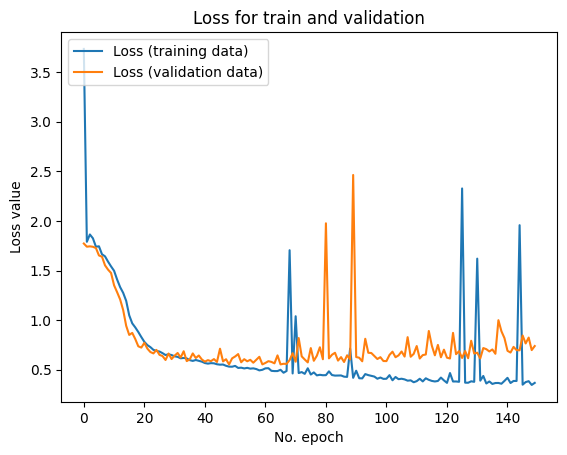

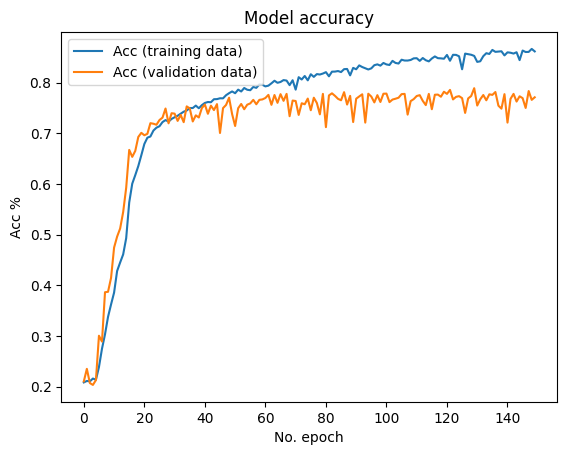

<Figure size 640x480 with 0 Axes>

In [22]:
loss,acc = Model.evaluate(X_val, y_val, verbose=2)

print(loss, acc)

plt.plot(history.history["loss"], label="Loss (training data)")
plt.plot(history.history["val_loss"], label="Loss (validation data)")
plt.title("Loss for train and validation")
plt.ylabel("Loss value")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()
plt.savefig("plots/Loss_big.png")

#Plot history: Accuracy
plt.plot(history.history["categorical_accuracy"], label="Acc (training data)")
plt.plot(history.history["val_categorical_accuracy"], label="Acc (validation data)")
plt.title("Model accuracy")
plt.ylabel("Acc %")
plt.xlabel("No. epoch")
plt.legend(loc="upper left")
plt.show()
plt.savefig("plots/Accuracy_big.png")

112/112 [==============================] - 2s 19ms/step


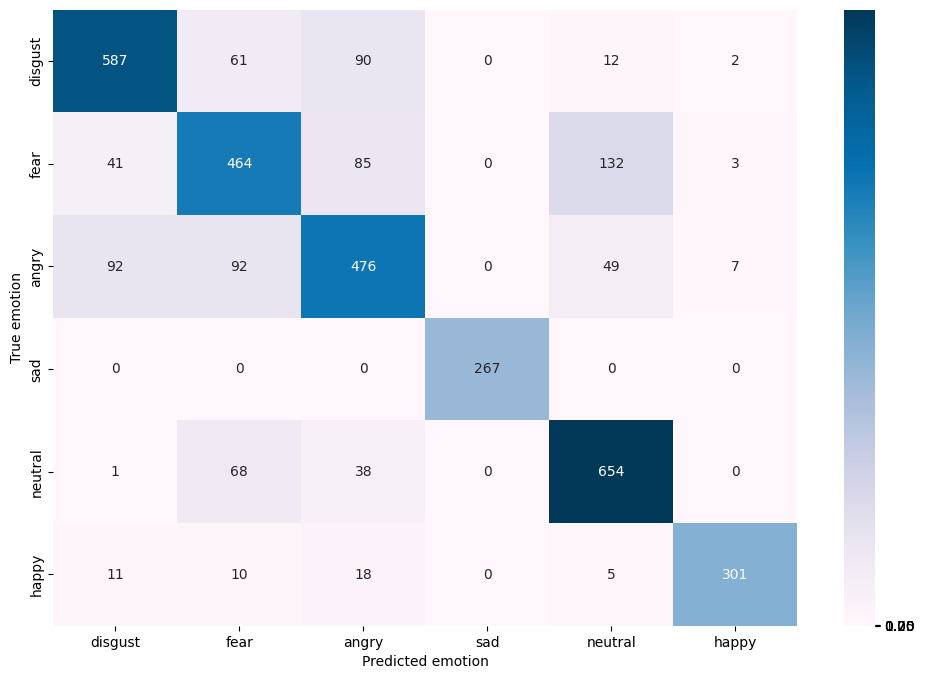

In [23]:
y_val_class = np.argmax(y_val, axis=1)
predictions = Model.predict(X_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)


#enc_labes = {"angry": 0, "happy": 1, "neural": 2, "sad":3}
index = ["disgust", "fear", "angry","sad","neutral","happy"]  
columns = ["disgust", "fear", "angry","sad","neutral","happy"]  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax,  annot=True, cmap = "PuBu", fmt="d" ) #cbar_kws={'format': '%.0f%%'},
ax.set_ylabel("True emotion")
ax.set_xlabel("Predicted emotion")
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .2, .75, 1])
# cbar.set_ticklabels(['low', '20%', '75%', '100%'])
plt.savefig("plots/Confmatrix.png")


In [24]:
values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print("Validation set predicted emotions accuracy:")
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
disgust : 0.7806
fear : 0.6400
angry : 0.6648
sad : 1.0000
neutral : 0.8594
happy : 0.8725


In [16]:
def save_model(model):
    model_json = model.to_json()
    with open("models/model_seq_big.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("models/model_seq_big.h5")

    json_file= open("models/model_seq_big.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("models/model_seq_big.h5")

    return loaded_model


In [25]:
model_json = Model.to_json()
with open("models/model_seq_big_2.json", "w") as json_file:
    json_file.write(model_json)
Model.save_weights("models/model_seq_big_2.h5")

In [26]:
pred = Model.predict(X_test)
y_pred_class = np.argmax(predictions, axis=1)

28/28 [==============================] - 1s 19ms/step


In [27]:
prediction_test = Model.predict(X_test)
y_pred = encoder.inverse_transform(prediction_test)

y_test = encoder.inverse_transform(y_test)
y_new = encoder.fit_transform(y_test)
y_new
df_ = pd.DataFrame( y_pred, y_test)


28/28 [==============================] - 1s 18ms/step


In [31]:
df_.sample(20)

,0
"(happy,)",happy
"(happy,)",happy
"(sad,)",sad
"(happy,)",happy
"(sad,)",happy
"(happy,)",angry
"(disgust,)",disgust
"(happy,)",happy
"(sad,)",sad
"(disgust,)",disgust
